In [1]:
import logging
import math
import os
import sys
from dataclasses import dataclass, field
from typing import Optional
from pathlib import Path
import pandas as pd
import numpy as np
import itertools

from datasets import load_dataset
import torch

import transformers
from transformers import (
    CONFIG_MAPPING,
    MODEL_FOR_CAUSAL_LM_MAPPING,
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint, is_main_process

In [2]:
import util

In [3]:
# set huggingface cache dir to prevent filling up home dir
os.environ['HF_HOME'] = '/net/scratch/shangao/latent-concept/cache'

In [4]:
print(f'available devices: {torch.cuda.device_count()}')
print(f'current device: {torch.cuda.current_device()}')
print(f'device name: {torch.cuda.get_device_name()}')

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using: " + str(device))

available devices: 1
current device: 0
device name: NVIDIA A100 80GB PCIe
using: cuda


In [5]:
set_seed(1234)

## load pretrained model

In [6]:
n_events = 5
model_name_or_path = '/net/scratch/shangao/latent-concept/outputs_small/pretrain/T5/checkpoint-155'
# model_name_or_path = '/net/scratch/shangao/latent-concept/outputs_small/pretrain/rdn_T5/checkpoint-155'
# model_name_or_path = 'gpt2'

In [7]:
# model config
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L354
config_kwargs = {
    "cache_dir": None,
    "revision": "main",
    "use_auth_token": None,
}
# load from checkpoint
config = AutoConfig.from_pretrained(model_name_or_path, **config_kwargs)

In [8]:
# tokenizer config
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L367
tokenizer_kwargs = {
    "cache_dir": None,
    "use_fast": True,
    "revision": "main",
    "use_auth_token": None,
}
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, **tokenizer_kwargs)

In [9]:
# small_model
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L393
# config.vocab_size = tokenizer.vocab_size
config.vocab_size = len(tokenizer)  # len(tokenizer) = tokenizer.vocab_size + 1 due to <|endoftext|>
config.n_layer = 4
config.n_head = 12

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    from_tf=bool(".ckpt" in model_name_or_path),
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
).to(device)

## load untrained model

In [26]:
model_type = 'gpt2'
n_events = 5

In [27]:
# model config is needed for loading tokenizer from json
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L354
config_kwargs = {
    "cache_dir": None,
    "revision": "main",
    "use_auth_token": None,
}
config = CONFIG_MAPPING[model_type]()

In [28]:
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L367
tokenizer_kwargs = {
    "cache_dir": None,
    "use_fast": True,
    "revision": "main",
    "use_auth_token": None,
}
# config = AutoConfig.from_pretrained('gpt2') 
# tokenizer = AutoTokenizer.from_pretrained('gpt2', tokenizer_file="/net/scratch/shangao/latent-concept/data/tokenizer.json", config=AutoConfig.from_pretrained('gpt2'), **tokenizer_kwargs)

# tokenizer = AutoTokenizer.from_pretrained(model_type, tokenizer_file="/net/scratch/shangao/latent-concept/data/tokenizer.json", config=config, **tokenizer_kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_type, tokenizer_file=f"/net/scratch/shangao/latent-concept/data/tokenizer_{n_events}.json", config=config, **tokenizer_kwargs)

tokenizer.pad_token = tokenizer.eos_token

In [29]:
# small_model
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L393
config.vocab_size = tokenizer.vocab_size
config.n_layer = 4
config.n_head = 12

In [30]:
# train a new model from scratch
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L409
model_raw = AutoModelForCausalLM.from_config(config).to(device)
model_raw.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(7, 768)

## datasets

In [280]:
# probs_test_gt = util.normalize([3, 1, 1], ord=1)
# probs_test_gt

In [124]:
prompt_len = 50

In [125]:
# load
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L332

data_files = {}
# data_files["validation"] = f'/net/scratch/shangao/latent-concept/data/agg_val_prompts_T{n_events}_N500_L{prompt_len}_E0.3.json'
# data_files["validation"] = f'/net/scratch/shangao/latent-concept/data/agg311_val_prompts_noend_T{n_events}_N500_L{prompt_len}_E0.3.json'
# data_files["validation"] = f'/net/scratch/shangao/latent-concept/data/unseen1s_val_prompts_noend_T{n_events}_N500_L{prompt_len}_E0.3.json'
# data_files["validation"] = f'/net/scratch/shangao/latent-concept/data/agg111_val_prompts_noend_T{n_events}_N500_L{prompt_len}_E0.3.json'
# data_files["validation"] = f'/net/scratch/shangao/latent-concept/data/agg100_val_prompts_noend_T{n_events}_N500_L{prompt_len}_E0.3.json'
# data_files["validation"] = f'/net/scratch/shangao/latent-concept/data/agg03503320318_val_prompts_noend_T{n_events}_N500_L{prompt_len}_E0.3.json'
data_files["validation"] = f'/net/scratch/shangao/latent-concept/data/rdn_val_prompts_noend_T{n_events}_N500_L{prompt_len}_E0.3.json'

extension = (
    list(data_files.values())[0].split(".")[-1]
)
if extension == "txt":
    extension = "text"

datasets = load_dataset(extension, data_files=data_files)

Generating validation split: 0 examples [00:00, ? examples/s]

In [126]:
# tokenize
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L433

def tokenize_function(examples):
    return tokenizer(examples['text'])

column_names = datasets["validation"].column_names
column_names.remove('labels')
tokenized_datasets = datasets.map(
    tokenize_function,
    batched=True,
    num_proc=1,
    remove_columns=column_names,
    load_from_cache_file=False,
)

Map:   0%|          | 0/409 [00:00<?, ? examples/s]

In [383]:
# # set block_size
# # https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L444
# block_size = min(1024, tokenizer.model_max_length)

In [ ]:
# # https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L461
# # Main data processing function that will concatenate all texts from our dataset and generate chunks of block_size.
# def group_texts(examples):
#     # Concatenate all texts.
#     concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
#     total_length = len(concatenated_examples[list(examples.keys())[0]])
#     # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
#     # customize this part to your needs.
#     total_length = (total_length // block_size) * block_size
#     # Split by chunks of max_len.
#     result = {
#         k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
#         for k, t in concatenated_examples.items()
#     }
#     result["labels"] = result["input_ids"].copy()
#     return result

# # Note that with `batched=True`, this map processes 1,000 texts together, so group_texts throws away a remainder for each of those groups of 1,000 texts. You can adjust that batch_size here but a higher value might be slower to preprocess.
# # To speed up this part, we use multiprocessing. See the documentation of the map method for more information: https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map
# lm_datasets = tokenized_datasets.map(
#     group_texts,
#     batched=True,
#     num_proc=1,
#     load_from_cache_file=False,
# )

## trainer

In [52]:
training_args = TrainingArguments(
    do_train=False,
    overwrite_output_dir=False,
    learning_rate=8e-4,
    num_train_epochs=5,
    # output_dir=f'/net/scratch/shangao/latent-concept/outputs_small/test_agg/T{n_events}',
    output_dir=f'/net/scratch/shangao/latent-concept/outputs_small/test_agg/rdn_T5',
    logging_steps=1,
    save_total_limit=4,
    eval_strategy='steps',
    # eval_strategy='epoch',
    save_steps=1500,
    warmup_steps=1000,
    lr_scheduler_type='linear',
    per_device_train_batch_size=8,  # 2
    gradient_accumulation_steps=4
)

In [53]:
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L494
trainer = Trainer(
    model=model,
    # model=model_raw,
    args=training_args,
    # train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    processing_class=tokenizer,
    # Data collator will default to DataCollatorWithPadding, so we change it.
    data_collator=default_data_collator,
)

In [55]:
logger = logging.getLogger(__name__)
results = {}

logger.info("*** Evaluate ***")
eval_output = trainer.evaluate()

perplexity = math.exp(eval_output["eval_loss"])
results["perplexity"] = perplexity
trainer.log_metrics("eval", results)
# trainer.save_metrics("eval", results)

trainer.log_metrics("eval", eval_output)
trainer.save_metrics("eval", eval_output)
trainer.save_state()

***** eval metrics *****
  perplexity = 5.1489
***** eval metrics *****
  eval_loss                   =     1.6388
  eval_model_preparation_time =     0.0008
  eval_runtime                = 0:00:00.05
  eval_samples_per_second     =    174.453
  eval_steps_per_second       =     38.767


## discrete gt concepts

In [428]:
# RSA: 
# 1. emb <> concept_pretrain_gt
# 2. emb sim pattern change with concept_pretrain_gt

emb = model.get_input_embeddings().weight.detach().cpu().numpy()
emb

array([[-0.03374935, -0.04000997, -0.03310606, ...,  0.01313341,
        -0.00937015, -0.01341357],
       [-0.00878116,  0.02785807,  0.03293291, ..., -0.02835299,
         0.03046143, -0.01993725],
       [-0.01284191, -0.00288289, -0.02557824, ...,  0.00135371,
        -0.01832302,  0.00940529],
       ...,
       [-0.01030629, -0.01018223,  0.01586098, ...,  0.01372947,
         0.01700575, -0.02273737],
       [ 0.00723821, -0.01609349,  0.05417285, ...,  0.02316959,
         0.01102453, -0.0232906 ],
       [-0.00586121, -0.00326788,  0.00942897, ...,  0.00531936,
         0.00112016, -0.01277776]], dtype=float32)

In [429]:
tokenizer.convert_tokens_to_ids('d')

4

In [430]:
emb = emb[1:n_events]
emb.shape

(4, 768)

In [433]:
np.corrcoef(emb)

array([[ 1.        , -0.04398745, -0.04511625,  0.00373317],
       [-0.04398745,  1.        , -0.049116  , -0.02302997],
       [-0.04511625, -0.049116  ,  1.        , -0.00102907],
       [ 0.00373317, -0.02302997, -0.00102907,  1.        ]])

<Axes: >

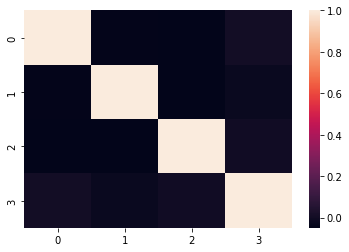

In [432]:
import seaborn as sns
sns.heatmap(np.corrcoef(emb))

## aggregate concepts

In [13]:
# event2state
import pickle
with open(f"/net/scratch/shangao/latent-concept/data/state2event_T{n_events}.pkl", "rb") as f:
    state2event = pickle.load(f)
print(state2event)

event2state = np.full(n_events, np.nan)
for state, events in state2event.items():
    event2state[events] = state
print(event2state)

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4]}
[0. 1. 2. 3. 4.]


In [127]:
# eval inf
# https://github.com/shaangao/incontext-learning/blob/84fab2141381001e33b5835e01f4fbf37f34a6a5/run_clm.py#L184

batch = torch.tensor(tokenized_datasets['validation']['input_ids']).to(device)
length = batch.shape[1]
print(length)

model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids=batch,
        # max_length=21,
        max_new_tokens=1,
        temperature=0.0,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

50


In [128]:
event_emb_pred = out[:, length]
# event_emb_pred

In [129]:
# since event idx is the same as event emb idx, we directly use event emb idx as event idx
state_pred = event2state[event_emb_pred.detach().cpu().numpy()]
state_pred

array([2., 4., 1., 2., 2., 4., 2., 3., 2., 4., 3., 2., 4., 2., 1., 2., 1.,
       2., 2., 2., 4., 1., 1., 4., 2., 4., 1., 1., 1., 1., 3., 2., 1., 2.,
       4., 3., 3., 1., 4., 1., 4., 1., 4., 2., 1., 4., 3., 2., 4., 4., 1.,
       2., 4., 3., 2., 1., 1., 2., 4., 4., 4., 4., 4., 2., 1., 2., 4., 3.,
       3., 2., 3., 3., 2., 1., 2., 2., 4., 1., 4., 4., 4., 2., 1., 2., 2.,
       1., 1., 4., 1., 2., 1., 3., 2., 1., 2., 3., 1., 2., 2., 1., 2., 2.,
       2., 2., 1., 2., 1., 2., 1., 4., 1., 2., 4., 1., 1., 4., 2., 2., 3.,
       2., 4., 2., 2., 3., 2., 4., 4., 2., 3., 1., 3., 4., 2., 2., 1., 4.,
       2., 4., 2., 1., 3., 3., 3., 2., 3., 4., 4., 1., 1., 1., 3., 1., 3.,
       3., 1., 2., 2., 4., 1., 2., 3., 4., 4., 2., 2., 2., 2., 2., 3., 4.,
       4., 4., 4., 4., 3., 3., 1., 3., 1., 2., 1., 2., 4., 4., 2., 1., 4.,
       4., 2., 4., 2., 3., 4., 2., 1., 4., 2., 2., 4., 3., 1., 2., 3., 2.,
       4., 2., 2., 4., 2., 3., 2., 2., 3., 3., 2., 2., 4., 1., 2., 2., 1.,
       1., 1., 2., 2., 2.

In [130]:
state_gt = tokenized_datasets['validation']['labels']

accuracy = sum(state_pred == state_gt) / len(state_gt)
accuracy

0.24938875305623473

In [131]:
sum(state_pred == state_gt)

102

## plots

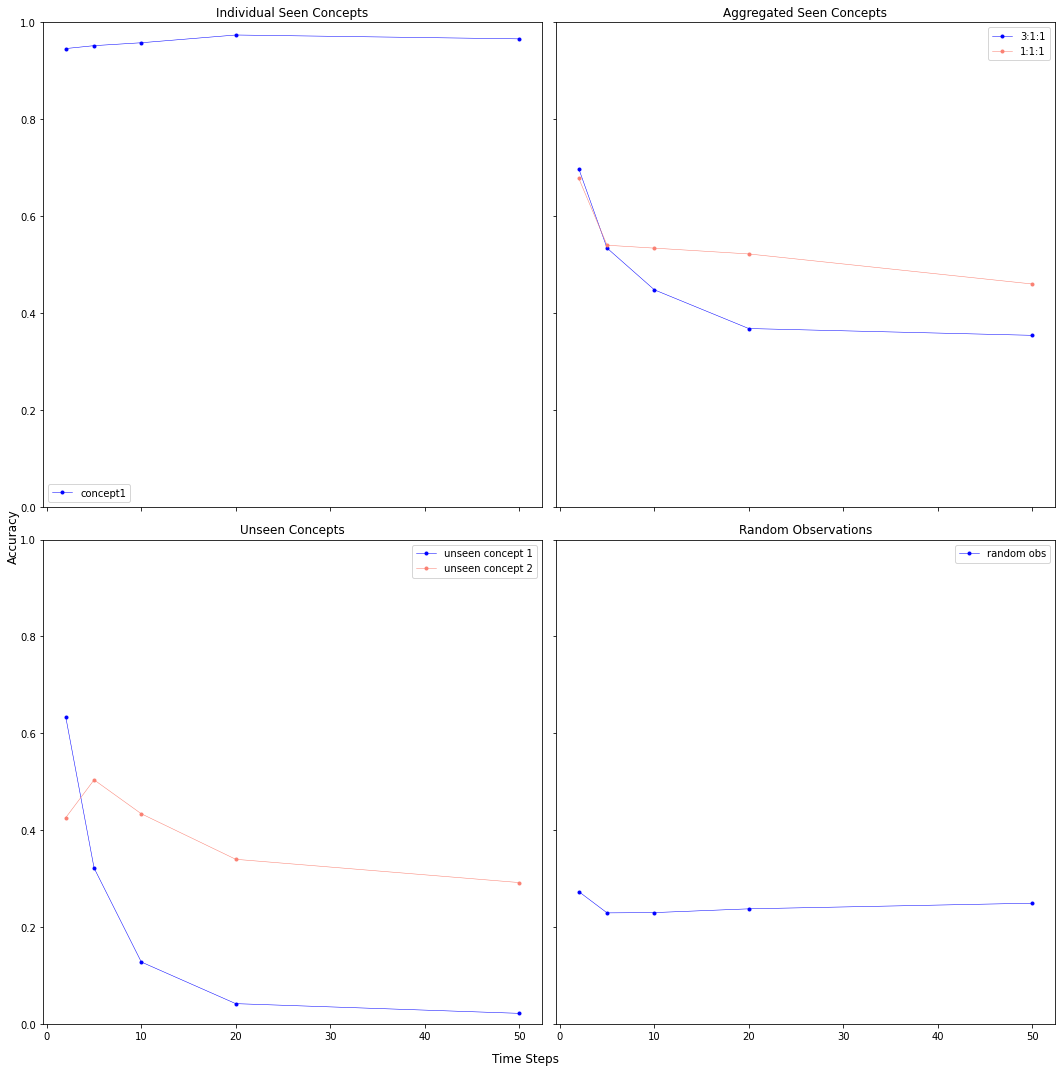

In [148]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)


axs[0,0].plot([2, 5, 10, 20, 50], [0.946, 0.952, 0.958, 0.974, 0.966], marker='.', linestyle='-', color='b', label=f'concept1', linewidth=.5)
axs[0,0].set_title('Individual Seen Concepts')
# axs[0,0].set_xlabel('Time Steps')
# axs[0,0].set_ylabel('Convergence')
axs[0,0].set_ylim(0, 1)
axs[0,0].legend()


axs[0,1].plot([2, 5, 10, 20, 50], [0.698, 0.534, 0.448, 0.368, 0.354], marker='.', linestyle='-', color='b', label=f'3:1:1', linewidth=.5)
axs[0,1].plot([2, 5, 10, 20, 50], [0.678, 0.54, 0.534, 0.522, 0.46], marker='.', linestyle='-', color='salmon', label=f'1:1:1', linewidth=.5)
axs[0,1].set_title('Aggregated Seen Concepts')
# axs[0,1].set_xlabel('Time Steps')
# axs[0,1].set_ylabel('Convergence')
# axs[0,1].set_ylim(0, 1)
axs[0,1].legend()



axs[1,0].plot([2, 5, 10, 20, 50], [0.634, 0.322, 0.128, 0.042, 0.022], marker='.', linestyle='-', color='b', label=f'unseen concept 1', linewidth=.5)
axs[1,0].plot([2, 5, 10, 20, 50], [0.426, 0.504, 0.434, 0.34, 0.292], marker='.', linestyle='-', color='salmon', label=f'unseen concept 2', linewidth=.5)
axs[1,0].set_title('Unseen Concepts')
# axs[0,1].set_xlabel('Time Steps')
# axs[0,1].set_ylabel('Convergence')
# axs[0,1].set_ylim(0, 1)
axs[1,0].legend()

axs[1,1].plot([2, 5, 10, 20, 50], [0.2733990147783251, 0.22938144329896906, 0.23, 0.23774509803921567, 0.24938875305623473], marker='.', linestyle='-', color='b', label=f'random obs', linewidth=.5)
axs[1,1].set_title('Random Observations')
# axs[0,1].set_xlabel('Time Steps')
# axs[0,1].set_ylabel('Convergence')
# axs[0,1].set_ylim(0, 1)
axs[1,1].legend()


fig.supxlabel('Time Steps')
fig.supylabel('Accuracy')
plt.tight_layout()
plt.show()